In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from airsea.windstress import stress
from matplotlib import mlab
import scipy.signal as signal
from physoce import tseries as ts
import gsw

def rot(u,v,theta):
    w = u + 1j*v
    ang = theta*np.pi/180
    wr = w*np.exp(1j*ang)
    ur = np.real(wr)
    vr = np.imag(wr)
    return ur,vr

def princax(u,v=None):

    # if one input only, decompose complex vector
    if v is None:
        w = np.copy(u)
        u = np.real(w)
        v = np.imag(w)

    # only use finite values for covariance matrix
    ii = np.isfinite(u+v)
    uf = u[ii]
    vf = v[ii]

    # compute covariance matrix
    C = np.cov(uf,vf)

    # calculate principal axis angle (ET, Equation 4.3.23b)
    theta = 0.5*np.arctan2(2.*C[0,1],(C[0,0] - C[1,1])) * 180/np.pi

    # calculate variance along major and minor axes (Equation 4.3.24)
    term1 = C[0,0] + C[1,1]
    term2 = ((C[0,0] - C[1,1])**2 + 4*(C[0,1]**2))**0.5
    major = np.sqrt(0.5*(term1 + term2))
    minor = np.sqrt(0.5*(term1 - term2))

    return theta,major,minor

ncfile = 'http://thredds.dataexplorer.oceanobservatories.org/thredds/dodsC/ooigoldcopy/public/CE01ISSM-MFD35-04-ADCPTM000-recovered_inst-adcp_velocity_earth/deployment0011_CE01ISSM-MFD35-04-ADCPTM000-recovered_inst-adcp_velocity_earth.ncml'
ds = xr.open_dataset(ncfile)

zero = np.zeros(len(ds['time']))

C:\Users\asche\Anaconda3\envs\reu21\lib\site-packages\airsea-0.0.1-py3.9.egg\airsea\atmosphere.py:363: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\asche\Anaconda3\envs\reu21\lib\site-packages\airsea-0.0.1-py3.9.egg\airsea\atmosphere.py:365: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\asche\Anaconda3\envs\reu21\lib\site-packages\airsea-0.0.1-py3.9.egg\airsea\atmosphere.py:363: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\asche\Anaconda3\envs\reu21\lib\site-packages\airsea-0.0.1-py3.9.egg\airsea\atmosphere.py:365: SyntaxWarning: "is" with a literal. Did you mean "=="?


(18078.0, 18108.0)

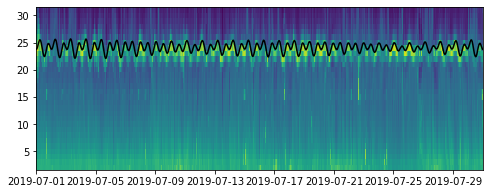

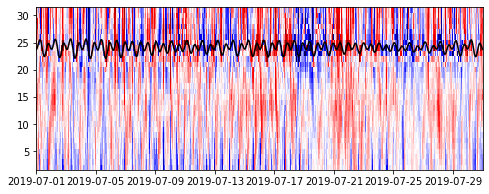

In [2]:
ds['u'] = ds['eastward_seawater_velocity']
ds['u'].attrs['units'] = 'm/s'

ds['v'] = ds['northward_seawater_velocity']
ds['v'].attrs['units'] = 'm/s'

#go from bins to depths
ds['bin_height'] = ds['depth_from_pressure'][0] - ds['bin_depths'][0,:]
ds['bin_height'].attrs['units'] = 'm'

ds['bin_depths_avg'] = ds['bin_height']-np.mean(ds['depth_from_pressure'])
ds['bin_depths_avg'].attrs['units'] = 'm'

ds['sea_surface'] = ds['depth_from_pressure']-np.mean(ds['depth_from_pressure'])
ds['sea_surface'].attrs['units'] = 'm'

ds['bottom_depth_avg'] = np.mean(ds['depth_from_pressure'])
ds['bottom_depth_avg'].attrs['units'] = 'm'

t1 = np.datetime64('2019-07-01 00:00:00')
t2 = np.datetime64('2019-07-31 00:00:00')

plt.figure(figsize=(8,3))
plt.pcolor(ds['time'],ds['bin_height'],
           ds['corrected_echo_intensity_beam1'].T, shading='auto')
plt.plot(ds['time'],ds['depth_from_pressure'],'k-')
plt.xlim([t1,t2])

plt.figure(figsize=(8,3))
plt.pcolor(ds['time'],ds['bin_height'],ds['u'].T,cmap='seismic', shading='auto')
plt.plot(ds['time'],ds['depth_from_pressure'],'k-') # convert from dPa to dbar
plt.clim([-0.4,0.4])
plt.xlim([t1,t2])

Text(0.5, 1.0, 'eastern water velocity')

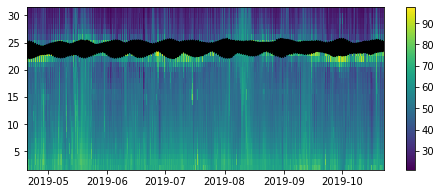

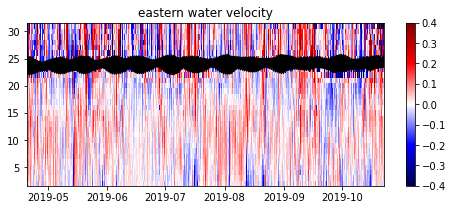

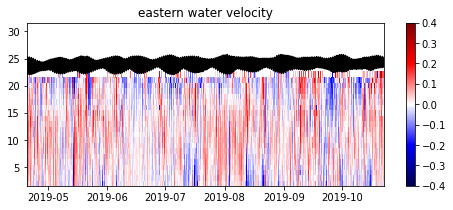

In [3]:
good = (ds['bin_depths'] > 3)

plt.figure(figsize=(8,3))
plt.pcolor(ds['time'],ds['bin_height'],
           ds['corrected_echo_intensity_beam1'].T, shading='auto')
plt.plot(ds['time'],ds['depth_from_pressure'],'k-')
plt.colorbar()

plt.figure(figsize=(8,3))
plt.pcolor(ds['time'],ds['bin_height'],ds['u'].T,cmap='seismic', shading='auto')
plt.plot(ds['time'],ds['depth_from_pressure'],'k-') # convert from dPa to dbar
plt.clim([-0.4,0.4])
plt.colorbar()
plt.title('eastern water velocity')

plt.figure(figsize=(8,3))
plt.pcolor(ds['time'],ds['bin_height'],ds['u'].where(good).T,cmap='seismic', shading='auto')
plt.plot(ds['time'],ds['depth_from_pressure'],'k-') # convert from dPa to dbar
plt.clim([-0.4,0.4])
plt.colorbar()
plt.title('eastern water velocity')

Text(0.5, 1.0, 'northward water velocity')

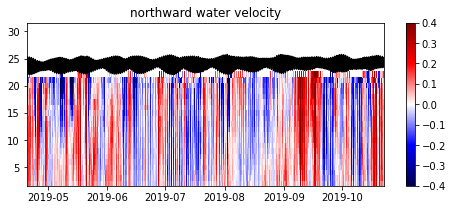

In [4]:
t1 = np.datetime64('2019-07-01 00:00:00')
t2 = np.datetime64('2019-07-15 00:00:00')

plt.figure(figsize=(8,3))
plt.pcolor(ds['time'],ds['bin_height'],ds['v'].where(good).T,cmap='seismic', shading='auto')
plt.plot(ds['time'],ds['depth_from_pressure'],'k-') # convert from dPa to dbar
plt.clim([-0.4,0.4])
plt.colorbar()
plt.title('northward water velocity')

here we perform filtering on raw u,v data from dataset before applying additional depth averages and principal axis analysis

In [5]:
#to perform filtering, first assign new data array with pl64 applied to each cross shore/along shore data
#then merge this data array with the main dataset
temp = xr.DataArray(ts.pl64(ds['u'],0.5),coords=(ds['obs'],ds['bin']),dims=('obs','bin'),
                    name='u_fil')
ds = ds.merge(temp)
temp = xr.DataArray(ts.pl64(ds['v'],0.5),coords=(ds['obs'],ds['bin']),dims=('obs','bin'),
                    name='v_fil')
ds = ds.merge(temp)

after obtaining filtered data, now perform depth average and rotate into principal axis

(18048.0, 18138.0)

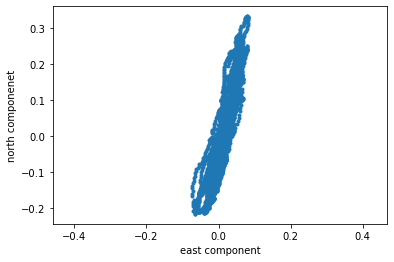

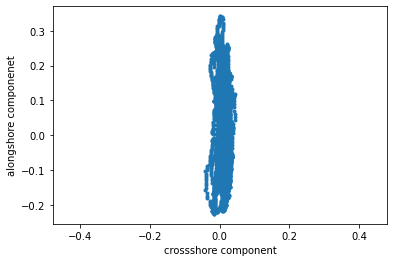

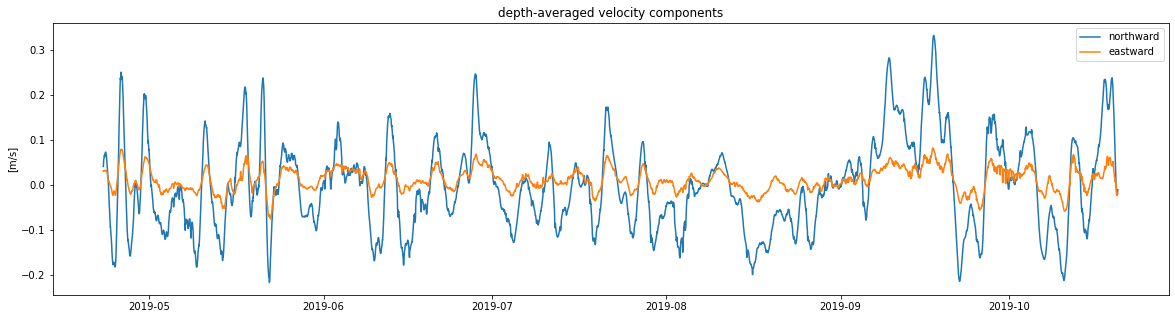

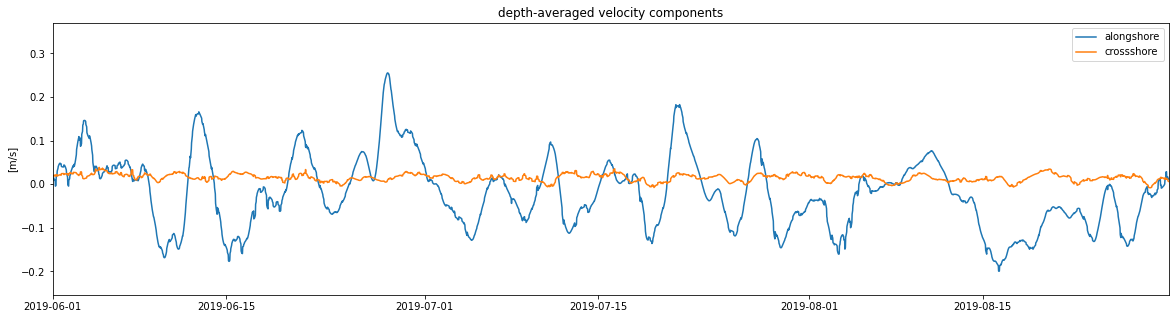

In [6]:
uda = ts.depthavg(ds['u_fil'].where(good),
                  ds['bin_depths_avg'],
                  ds['bottom_depth_avg'],
                  ds['sea_surface'])

vda = ts.depthavg(ds['v_fil'].where(good),
                  ds['bin_depths_avg'],
                  ds['bottom_depth_avg'],
                  ds['sea_surface'])

ds['uda'] = xr.DataArray(uda,dims='obs')
ds['uda'].attrs['units'] = 'm/s'
ds['vda'] = xr.DataArray(vda,dims='obs')
ds['vda'].attrs['units'] = 'm/s'

theta,major,minor = princax(ds['uda'],ds['vda'])
ds['cs_da'],ds['as_da'] = rot(ds['uda'],ds['vda'],-theta+90)

t1 = np.datetime64('2019-06-01 00:00:00')
t2 = np.datetime64('2019-08-30 00:00:00')

plt.figure()
plt.plot(ds['uda'], ds['vda'], linestyle='none', marker='.')
plt.xlabel('east component')
plt.ylabel('north componenet')
plt.axis('equal')

plt.figure()
plt.plot(ds['cs_da'], ds['as_da'], linestyle='none', marker='.')
plt.xlabel('crossshore component')
plt.ylabel('alongshore componenet')
plt.axis('equal')

plt.figure(figsize=(20,5))
plt.plot(ds['time'],ds['vda'])
plt.plot(ds['time'],ds['uda'])
plt.legend(['northward','eastward'])
plt.title('depth-averaged velocity components')
plt.ylabel('[m/s]')

plt.figure(figsize=(20,5))
plt.plot(ds['time'],ds['as_da'])
plt.plot(ds['time'],ds['cs_da'])
plt.legend(['alongshore','crossshore'])
plt.title('depth-averaged velocity components')
plt.ylabel('[m/s]')
plt.xlim([t1,t2])

rotate, filter, and plot velocity data with pl64 from physoce time series

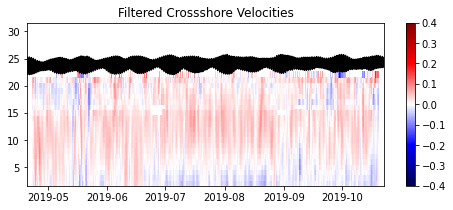

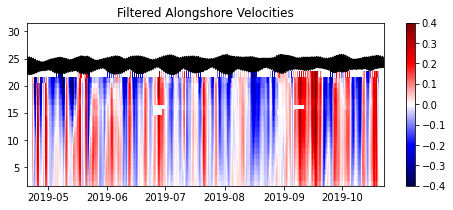

In [7]:
ds['cs_fil'],ds['as_fil'] = rot(ds['u_fil'],ds['v_fil'],-theta+90)

plt.figure(figsize=(8,3))
plt.pcolor(ds['time'],ds['bin_height'],ds['cs_fil'].where(good).T,cmap='seismic', shading='auto')
plt.plot(ds['time'],ds['depth_from_pressure'],'k-') # convert from dPa to dbar
plt.clim([-0.4,0.4])
plt.title('Filtered Crossshore Velocities')
plt.colorbar()

plt.figure(figsize=(8,3))
plt.pcolor(ds['time'],ds['bin_height'],ds['as_fil'].where(good).T,cmap='seismic', shading='auto')
plt.plot(ds['time'],ds['depth_from_pressure'],'k-') # convert from dPa to dbar
plt.clim([-0.4,0.4])
plt.title('Filtered Alongshore Velocities')
plt.colorbar()

Now time to work on finding baroclinic u, with depth average removed and filter applied.

Taking baroclinic crossshore velocity as the filtered velocity minus (should it be plus?) the depth average.

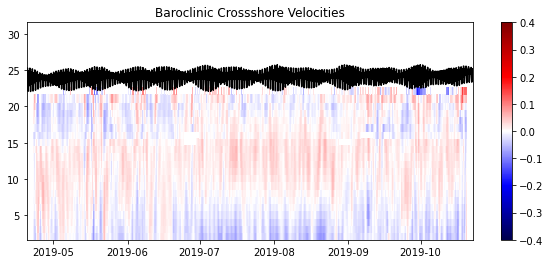

In [8]:
ds['cs_bar'] = ds['cs_fil'] - ds['cs_da']

plt.figure(figsize=(10,4))
plt.pcolor(ds['time'],ds['bin_height'],ds['cs_bar'].where(good).T,cmap='seismic', shading='auto')
plt.plot(ds['time'],ds['depth_from_pressure'],'k-') # convert from dPa to dbar
plt.clim([-0.4,0.4])
plt.title('Baroclinic Crossshore Velocities')
plt.colorbar()

redoing depth average to check post corrected crossshore flow

(18048.0, 18138.0)

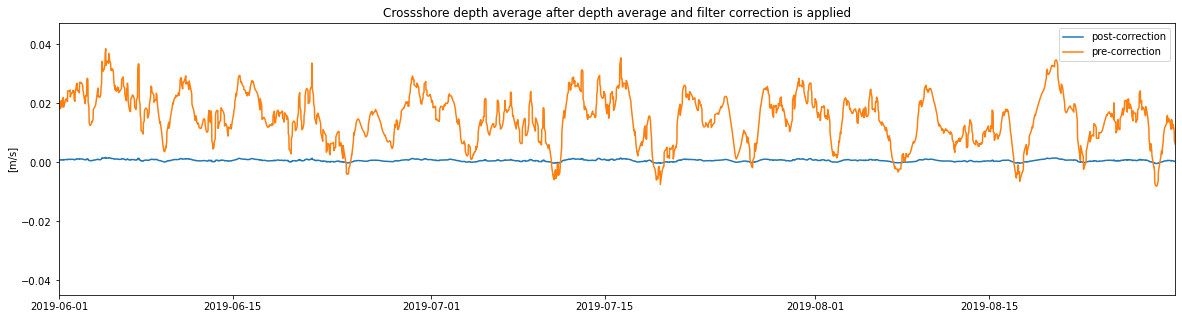

In [9]:
test = ts.depthavg(ds['cs_bar'].where(good),
                  ds['bin_depths_avg'],
                  ds['bottom_depth_avg'],
                  ds['sea_surface'])
ds['test'] = xr.DataArray(test,dims='obs')
ds['test'].attrs['units'] = 'm/s'

plt.figure(figsize=(20,5))
plt.plot(ds['time'],ds['test'])
plt.plot(ds['time'],ds['cs_da'])
plt.legend(['post-correction','pre-correction'])
plt.title('Crossshore depth average after depth average and filter correction is applied')
plt.ylabel('[m/s]')
plt.xlim([t1,t2])

begin wind analysis for qualitative comparison

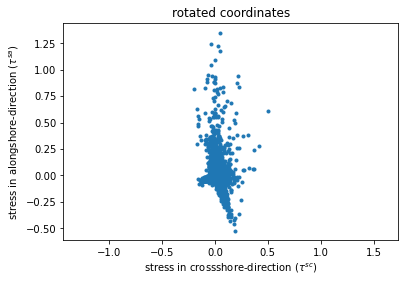

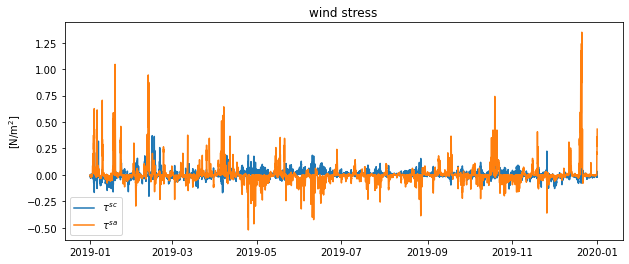

In [11]:
def wind_uv_from_spddir(wspd,wdir):
    theta = np.array(wdir)
    theta = theta*np.pi/180
    x = np.sin(theta)
    y = np.cos(theta)
    theta_cart = np.arctan2(y,x)
    u = -wspd*np.cos(theta_cart) #why should these be negative?
    v = -wspd*np.sin(theta_cart)
    return u,v

ncfile = 'https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/nwpo3/nwpo3h2019.nc'
ds_wind = xr.open_dataset(ncfile)

ds_wind = ds_wind.squeeze()

#get and plot alignment of wind velocity 

ds_wind['wind_east'],ds_wind['wind_north'] = wind_uv_from_spddir(ds_wind['wind_spd'], ds_wind['wind_dir'])

tau = stress(ds_wind['wind_spd'],z=4.1)
#wind stress in same direction as wind velocity, so get theta from arctan2 then use this to find components of tau
tau_east = tau*np.cos(np.arctan2(ds_wind['wind_north'],ds_wind['wind_east']))
tau_north = tau*np.sin(np.arctan2(ds_wind['wind_north'],ds_wind['wind_east']))

ds_wind['tau_east'] = (('time'), tau_east)
ds_wind['tau_north'] = (('time'), tau_north)

#rotate vectors to be in alongshore & crossshore direction
#theta,major,minor = princax(ds_wind['tau_east'],ds_wind['tau_north']) #rot angle is CCW rotation for vecotr or CW rotation for basis
ds_wind['tau_x'],ds_wind['tau_y'] = rot(ds_wind['tau_east'],ds_wind['tau_north'],-theta+90)

plt.figure()
plt.plot(ds_wind['tau_x'],ds_wind['tau_y'],'.')
plt.axis('equal')
plt.xlabel('stress in crossshore-direction ($\\tau^{sc}$)')
plt.ylabel('stress in alongshore-direction ($\\tau^{sa}$)')
plt.title('rotated coordinates')


plt.figure(figsize=(10,4))
plt.plot(ds_wind['time'],ds_wind['tau_x'])
plt.plot(ds_wind['time'],ds_wind['tau_y'])
plt.ylabel('[N/m$^2$]')
plt.title('wind stress')
plt.legend(['$\\tau^{sc}$','$\\tau^{sa}$'])

plotting above wind/water current plots for easier comparison

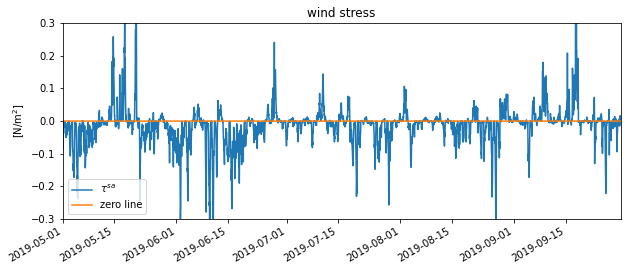

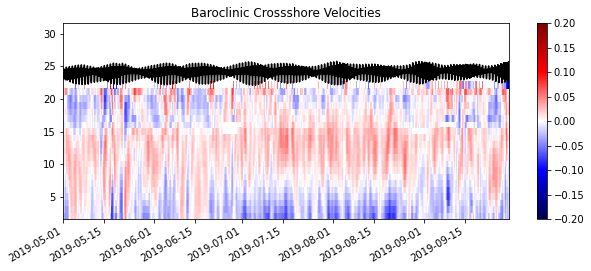

In [12]:
t1 = np.datetime64('2019-05-01 00:00:00')
t2 = np.datetime64('2019-09-30 00:00:00')

plt.figure(figsize=(10,4))
plt.plot(ds_wind['time'],ds_wind['tau_y'])
plt.plot(ds['time'],zero)
plt.ylabel('[N/m$^2$]')
plt.title('wind stress')
plt.legend(['$\\tau^{sa}$','zero line'], loc=3)
plt.xlim([t1,t2])
plt.ylim([-0.3,0.3])
plt.gcf().autofmt_xdate()

plt.figure(figsize=(10,4))
plt.pcolor(ds['time'],ds['bin_height'],ds['cs_bar'].where(good).T,cmap='seismic', shading='auto')
plt.plot(ds['time'],ds['depth_from_pressure'],'k-') # convert from dPa to dbar
plt.clim([-0.2,0.2])
plt.title('Baroclinic Crossshore Velocities')
plt.colorbar()
plt.xlim([t1,t2])
plt.gcf().autofmt_xdate()

looking at flow time series specifically (bin heights 3.1m, 13.1m, and 20.1m above bottom):

(-0.08, 0.08)

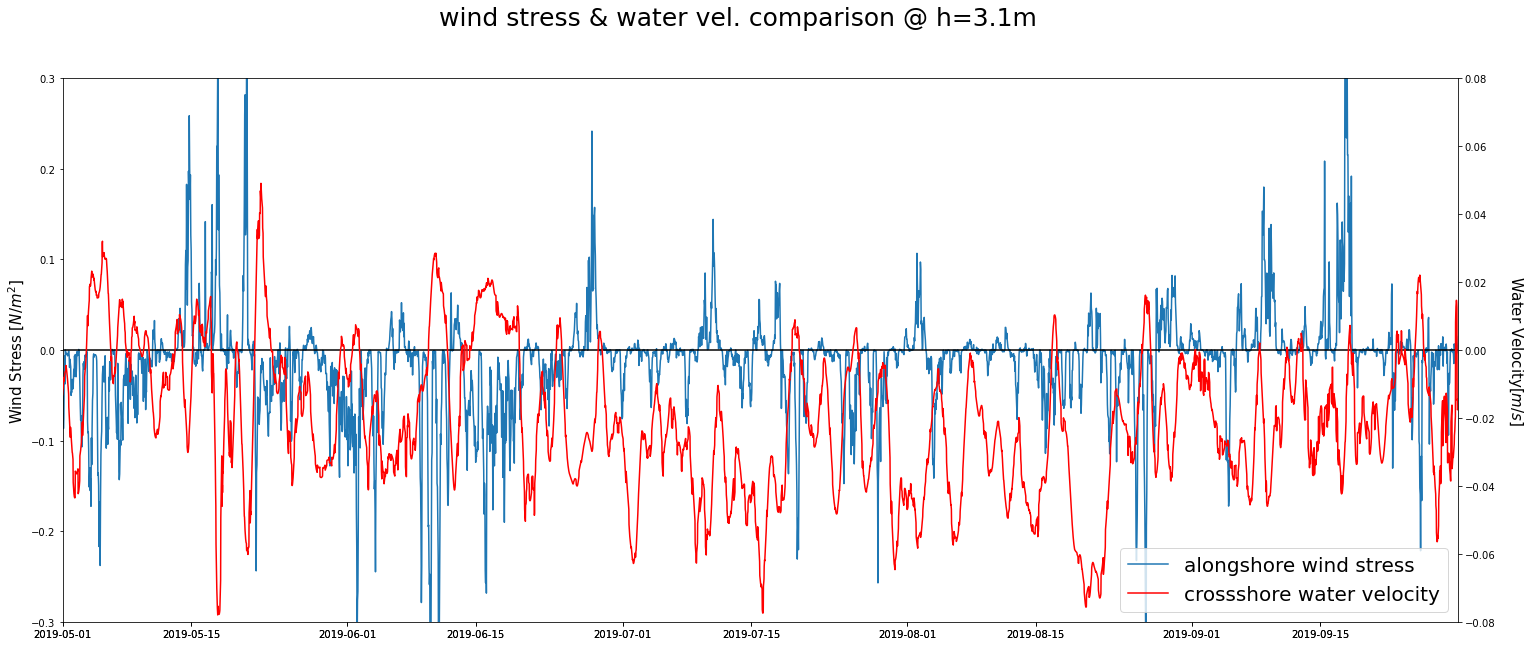

In [13]:
fig = plt.figure(figsize=(25,10))
fig.suptitle('wind stress & water vel. comparison @ h=3.1m', fontsize=25)


ax1 = fig.add_subplot(111)
lin1, = ax1.plot(ds_wind['time'],ds_wind['tau_y'])
ax1.set_ylabel("Wind Stress [$N/m^2$]", fontsize=15)


ax2 = fig.add_subplot(111, sharex=ax1, frameon=False)
lin2, = ax2.plot(ds['time'],zero,color='k')
lin3, = ax2.plot(ds['time'],ds['cs_bar'].T[1], color='r')
#lin4 = ax2.plot(ds['time'],ds['cs_bar'].T[11])
#lin5 = ax2.plot(ds['time'],ds['cs_bar'].T[18])
ax2.set_ylabel("Water Velocity[$m/s$]", rotation=270, labelpad=30, fontsize=15)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

ax1.legend((lin1,lin3),('alongshore wind stress','crossshore water velocity'), prop={'size': 20}, loc=4)
ax1.set_xlim([t1,t2])
ax1.set_ylim([-.3,.3])
ax2.set_ylim([-.08,.08])

(-0.08, 0.08)

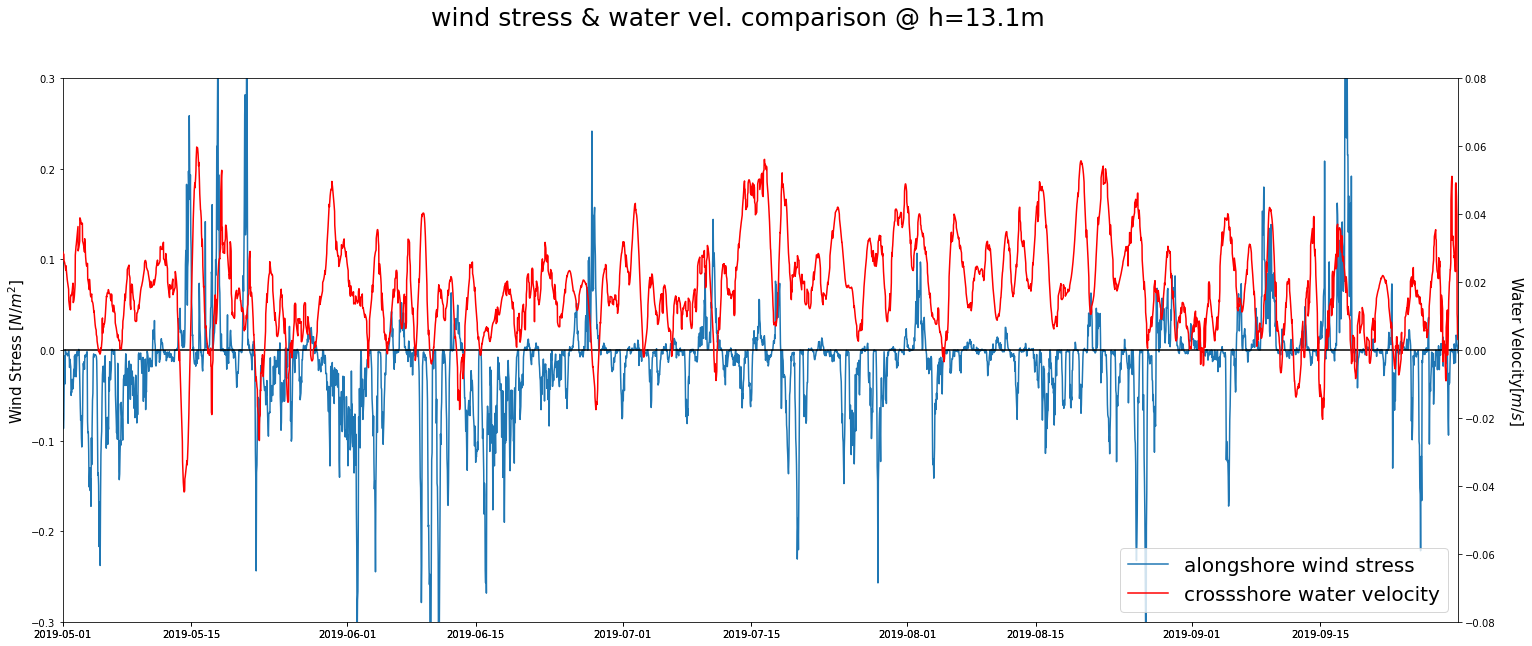

In [14]:
fig = plt.figure(figsize=(25,10))
fig.suptitle('wind stress & water vel. comparison @ h=13.1m', fontsize=25)


ax1 = fig.add_subplot(111, sharex=ax1)
lin1, = ax1.plot(ds_wind['time'],ds_wind['tau_y'])
ax1.set_ylabel("Wind Stress [$N/m^2$]", fontsize=15)


ax2 = fig.add_subplot(111, sharex=ax1, frameon=False)
lin2, = ax2.plot(ds['time'],zero,color='k')
lin3, = ax2.plot(ds['time'],ds['cs_bar'].T[11], color='r')
#lin4 = ax2.plot(ds['time'],ds['cs_bar'].T[11])
#lin5 = ax2.plot(ds['time'],ds['cs_bar'].T[18])
ax2.set_ylabel("Water Velocity[$m/s$]", rotation=270, labelpad=30, fontsize=15)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

ax1.legend((lin1,lin3),('alongshore wind stress','crossshore water velocity'), prop={'size': 20}, loc=4)
ax1.set_xlim([t1,t2])
ax1.set_ylim([-.3,.3])
ax2.set_ylim([-.08,.08])

(-0.08, 0.08)

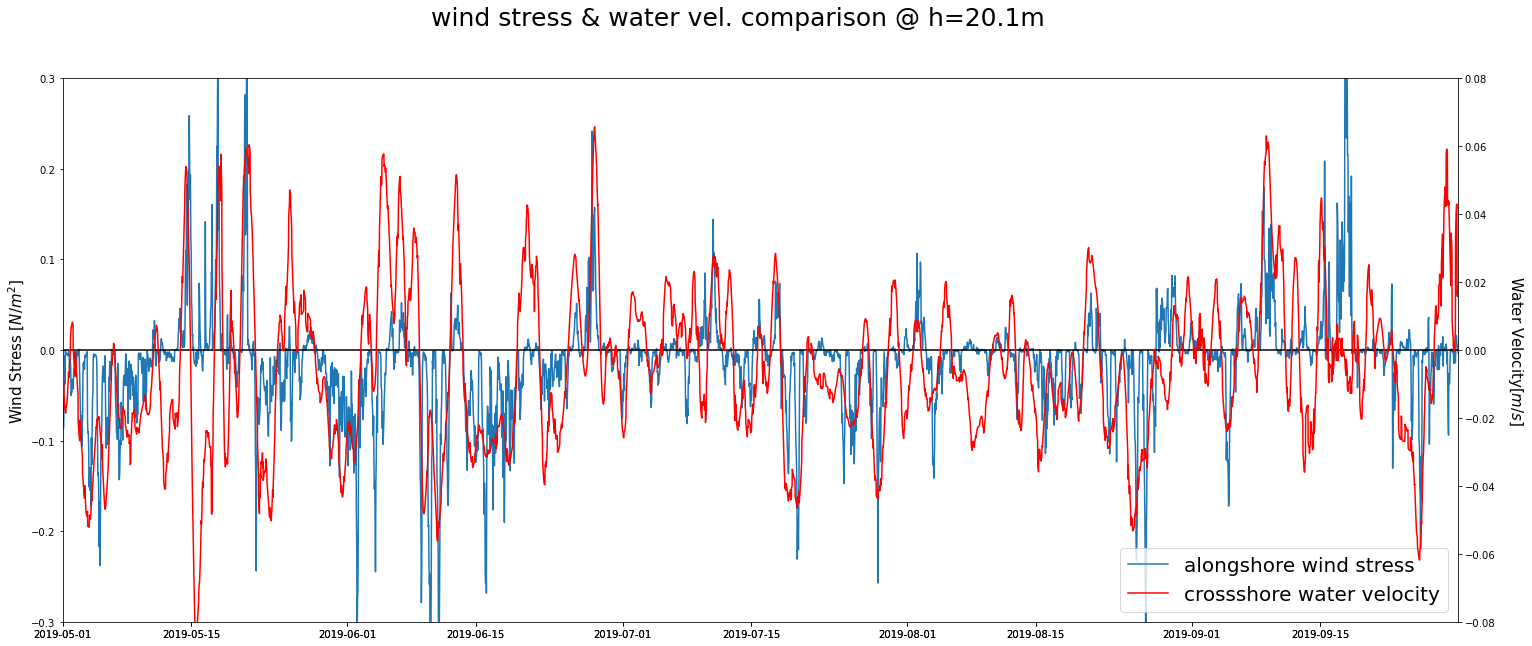

In [15]:
fig = plt.figure(figsize=(25,10))
fig.suptitle('wind stress & water vel. comparison @ h=20.1m', fontsize=25)


ax1 = fig.add_subplot(111, sharex=ax1)
lin1, = ax1.plot(ds_wind['time'],ds_wind['tau_y'])
ax1.set_ylabel("Wind Stress [$N/m^2$]", fontsize=15)


ax2 = fig.add_subplot(111, sharex=ax1, frameon=False)
lin2, = ax2.plot(ds['time'],zero,color='k')
lin3, = ax2.plot(ds['time'],ds['cs_bar'].T[18], color='r')
#lin4 = ax2.plot(ds['time'],ds['cs_bar'].T[11])
#lin5 = ax2.plot(ds['time'],ds['cs_bar'].T[18])
ax2.set_ylabel("Water Velocity[$m/s$]", rotation=270, labelpad=30, fontsize=15)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

ax1.legend((lin1,lin3),('alongshore wind stress','crossshore water velocity'), prop={'size': 20}, loc=4)
ax1.set_xlim([t1,t2])
ax1.set_ylim([-.3,.3])
ax2.set_ylim([-.08,.08])

Beginning sea surface trasnport analysis:

In [16]:
us, zs = ts.surface_transport(ds['cs_bar'].where(good),ds['bin_depths_avg'],ds['sea_surface'])
us

C:\Users\asche\Anaconda3\envs\reu21\lib\site-packages\physoce-0.0.2-py3.9.egg\physoce\tseries.py:531: RuntimeWarning: All-NaN slice encountered


array([nan, nan, nan, ..., nan, nan, nan])

Text(0, 0.5, 'Depth [m]')

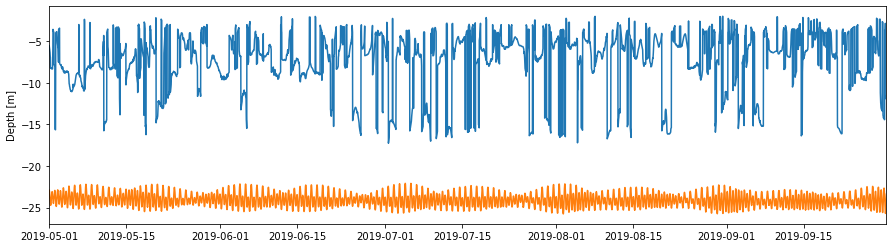

In [17]:
plt.figure(figsize=(15,4))
plt.plot(ds['time'],zs)
plt.plot(ds['time'],-ds['depth_from_pressure'])
plt.xlim([t1,t2])
plt.ylabel('Depth [m]')

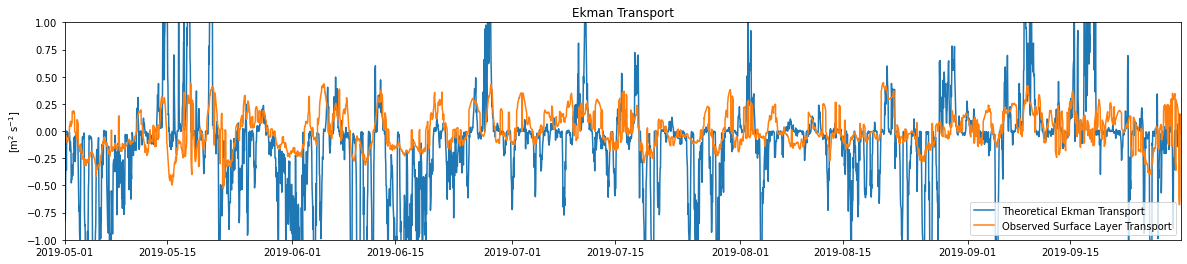

In [18]:
#compute theroetical ekman transport e.g. Kirincich & Barth
rho = 1026 #denisty of sea water kg/m3
f = gsw.f(ds_wind['latitude'].values) #coriolis parameter 1/s

ds_wind['uek'] = (('time'), ds_wind['tau_y']/(rho*f))

plt.figure(figsize=(20,4))
plt.plot(ds_wind['time'],ds_wind['uek'],label='Theoretical Ekman Transport')
plt.ylabel('[m$^2$ s$^{-1}$]')
plt.title('Ekman Transport')
plt.plot(ds['time'],us,label='Observed Surface Layer Transport')
plt.xlim([t1,t2])
plt.ylim([-1,1])
plt.legend()

(18017.0, 18169.0)

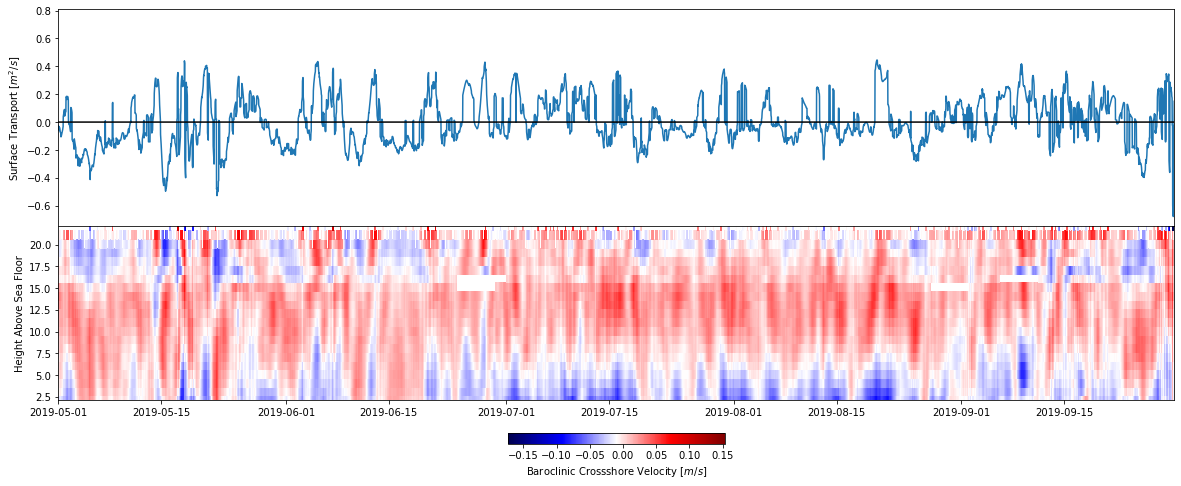

In [65]:
fig, (ax1,ax2) = plt.subplots(nrows=2,sharex=True,figsize=(20,8))
ax1.plot(ds['time'],us)
ax1.plot(ds['time'],zero,'-k')
pcolor = ax2.pcolor(ds['time'],ds['bin_height'],ds['cs_bar'].where(good).T,cmap='seismic', shading='auto')
ax1.set_ylabel('Surface Transport [$m^2/s$]')
ax2.set_ylabel('Height Above Sea Floor')
ax2.set_ylim([np.min(ds['bin_height'].where(good)),np.max(ds['bin_height'].where(good))])
#ax2.clim([-0.4,0.4])
#plt.title('Baroclinic Crossshore Velocities')
plt.colorbar(pcolor,location='bottom',orientation='horizontal',
             fraction=0.05,label='Baroclinic Crossshore Velocity [$m/s$]')
plt.subplots_adjust(wspace=0,hspace=0)
ax1.set_xlim([t1,t2])

Beginning surface buoy water velocity data analysis:

In [60]:
ncfile = 'http://thredds.dataexplorer.oceanobservatories.org/thredds/dodsC/ooigoldcopy/public/CE01ISSM-SBD17-04-VELPTA000-telemetered-velpt_ab_dcl_instrument/deployment0011_CE01ISSM-SBD17-04-VELPTA000-telemetered-velpt_ab_dcl_instrument.ncml'
ds_surf = xr.open_dataset(ncfile)

Text(0.5, 0, 'Crossshore Velocity [$m/s$]')

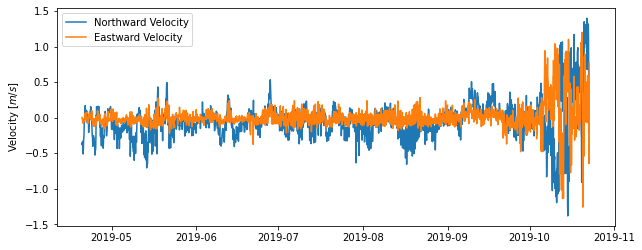

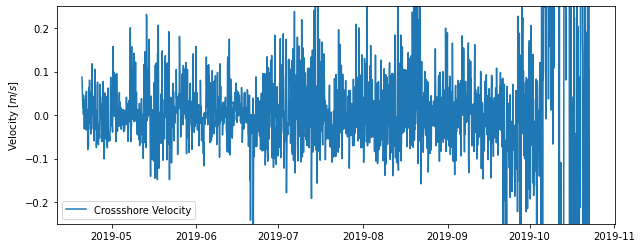

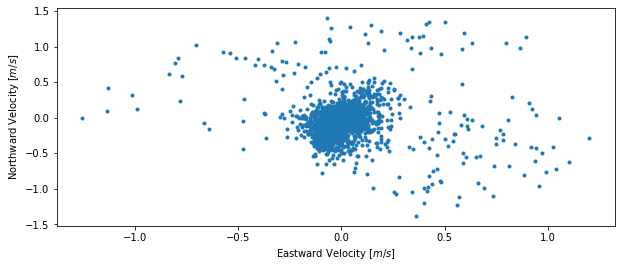

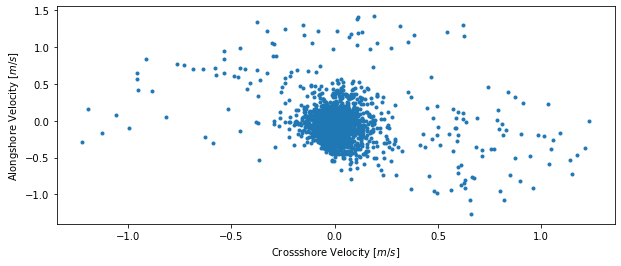

In [61]:
theta,major,minor = princax(ds['uda'],ds['vda']) #using prinicipal axis from sea bottom adcp data
ds_surf['cs'],ds_surf['as'] = rot(ds_surf['eastward_velocity'],ds_surf['northward_velocity'],-theta+90)

plt.figure(figsize=(10,4))
plt.plot(ds_surf['time'],ds_surf['northward_velocity'],label='Northward Velocity')
plt.plot(ds_surf['time'],ds_surf['eastward_velocity'],label='Eastward Velocity')
plt.ylabel('Velocity [$m/s$]')
plt.legend()

plt.figure(figsize=(10,4))
plt.plot(ds_surf['time'],ds_surf['cs'],label='Crossshore Velocity')
#plt.plot(ds_surf['time'],ds_surf['as'],label='Alongshore Velocity')
plt.ylabel('Velocity [$m/s$]')
plt.legend()
plt.ylim([-0.25,0.25])

plt.figure(figsize=(10,4))
plt.plot(ds_surf['eastward_velocity'],ds_surf['northward_velocity'],'.')
plt.ylabel('Northward Velocity [$m/s$]')
plt.xlabel('Eastward Velocity [$m/s$]')

plt.figure(figsize=(10,4))
plt.plot(ds_surf['cs'],ds_surf['as'],'.')
plt.ylabel('Alongshore Velocity [$m/s$]')
plt.xlabel('Crossshore Velocity [$m/s$]')

---Everything below here is unfinished work (trying to add surface readings to adcp data)---

In [ ]:
plt.figure(figsize=(8,3))
plt.pcolor(ds['time'],ds['bin_height'],ds['cs_bar'].where(good).T,cmap='seismic', shading='auto')
plt.pcolor(ds_surf['time'],ds_surf['bin_depths_avg'],ds_surf['cs'],cmap='seismic')
plt.plot(ds['time'],ds['depth_from_pressure'],'k-') # convert from dPa to dbar
plt.clim([-0.4,0.4])
plt.title('Filtered Crossshore Velocities')
plt.colorbar()

In [ ]:
ds